# 3. Оценка эффективности рекламных кампаний

In [2]:
# Загрузка библиотек
import pandas as pd
import sqlite3 as db

import datetime as dt
import multiprocessing
from multiprocessing import Pool, Manager

from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
import pprint
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score
from package.select_run_test import SampleComparisonTest

# Загрузим функции поиска во всех записях о товаре наиболее часто встречающихся значений признака "цвет"
# для наименований товаров, по которым есть записи с незаполненым признаком "цвет"
# (функции написаны в отдельном модуле для обеспечения требований блиотеки  multiprocessing)
from package.preparation import add_freq_product_color, freq_product_color

import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.ticker import FormatStrFormatter

from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score

## 3.1. Загрузка датасета, полученного в п.1 и п.2 исследования

In [29]:
# Загрузим итоговый датаcет из хранилища
connection = db.connect('data/purchases.db')
print("База данных подключена")
query = 'SELECT * FROM full_table'
df_all = pd.read_sql_query(query, connection)
print("Таблица загружена")
connection.close()
print("Соединение с базой данных закрыто")

База данных подключена
Таблица загружена
Соединение с базой данных закрыто


## 3.2. Оценка первой рекламной кампании

In [6]:
# Функция присвоения значения признаку проведения первой рекламной кампании
def f_indexes(df, col, file_name, value):
    def f(x, y, value, indexes):
        if x in indexes:
            return value
        else:
            return y
    
    indexes = list()
    with open(file_name) as file:
        while True:
            line = file.readline()
            if not line:
                break
            row = line[:-1].replace(' ', ',').replace(';', ',').split(',')
            for elem in row:
                if elem.isdigit():
                    indexes.append(int(elem))
    
    # Оставим только уникальные значения индексов
    indexes = list(set(indexes))
    print(f'Количество записей {file_name[-12:-4]}: {len(indexes)}')

    df[col] = df.apply(lambda x: f(x.id, x[col], value, indexes), axis=1)

    return df

In [7]:
# Добавим в датасет признак тестовой группы
col = 'test'
df_all[col] = None

# Заполним признак данными о тестовой группе потребителей
df_all = f_indexes(df_all, col, 'data/result_data/ids_first_company_positive.txt', 1)

# Заполним признак данными о контрольной группе потребителей
df_all = f_indexes(df_all, col, 'data/result_data/ids_first_company_negative.txt', 0)

Количество записей positive: 5016
Количество записей negative: 5009


**Вывод:** количество покупателей, совершивших покупки в тестовой и контрольной группах, сбалансировано. Соответсвенно тестовая и контрольные группы реливантны.

In [8]:
# Получим датасет выбранный для AB тестирования первой маркетенговой компании
df_AB_1 = df_all[~(df_all.test.isna()) & (df_all.dt<16)]
print(f'Количесвто записей для расчёта AB теста: {df_AB_1.shape[0]}')
# Датасеты тестовой и контрольной групп
df_test = df_AB_1[df_AB_1.test == 1]
df_control = df_AB_1[df_AB_1.test == 0]
print(f'Количество записей в тестовой группе: {len(df_test)}')
print(f'Количество записей в контрольной группе: {len(df_control)}')

Количесвто записей для расчёта AB теста: 47120
Количество записей в тестовой группе: 29850
Количество записей в контрольной группе: 17270


Эффективность проведённой рекламной кампании можно проверить по:
 - увеличению стоимости покупок покупателями,  
 - увеличению частоты покупок,
 - увеличение покупок группой клиентов в возрасной категории от 26 до 60 лет (как наиболее состоятельной)
 https://blog.domclick.ru/ipoteka/post/kazhduyu-desyatuyu-ipoteku-v-sbere-berut-molodye-lyudi-analitika-domklik

### 3.2.1. Проверим метрики "Увеличение стоимости покупок"

In [9]:
# Сформируем выборки по стоимости покупок покупателей
df_test_cost = df_test.groupby('dt').agg({'cost': 'sum'})
df_control_cost = df_control.groupby('dt').agg({'cost': 'sum'})

In [10]:
# Применим разработанный класс (см. файл package.select_run_test)
# для определения статистически значисого отличия сформированных выборок
test = SampleComparisonTest(print_console_flag=True)
test.select_run_test(df_test_cost['cost'], df_control_cost['cost'])


Пользователь задал условие - выборки НЕЗАВИСИМЫЕ

 Проверка каждой выборки на прараметричность тестом Шапира-Уилка
 ЗНАЧЕНИЯ p-value ВЫБОРОК
  - первая выборка: 56.596482%
  - вторая выборка: 0.270582%
--------------------------------------
 ВЫВОД: Одна или все выборки НЕПАРАМЕТРИЧЕСКИЕ (не распеределены по нормальному закону распределения)


  Для сравнения выборок выбран тест: Критерий Мана-Уитни
 ЗНАЧЕНИЕ p-value при тестировании выборок: 0.001593%
-------------------------------------------------------
 ВЫВОД: выборки статистически значимо РАЗЛИЧАЮТСЯ (гипотеза H1)


{'Условие зависимости выборок': 'no_dependency',
 'Предпроверка 1': {'name_test': 'Тест Шапиро',
  'p-value df1': 0.5659648180007935,
  'p-value df2': 0.0027058192063122988},
 'Результат': {'name_test': 'Критерий Мана-Уитни',
  'p-value': 1.5932777797286954e-05}}

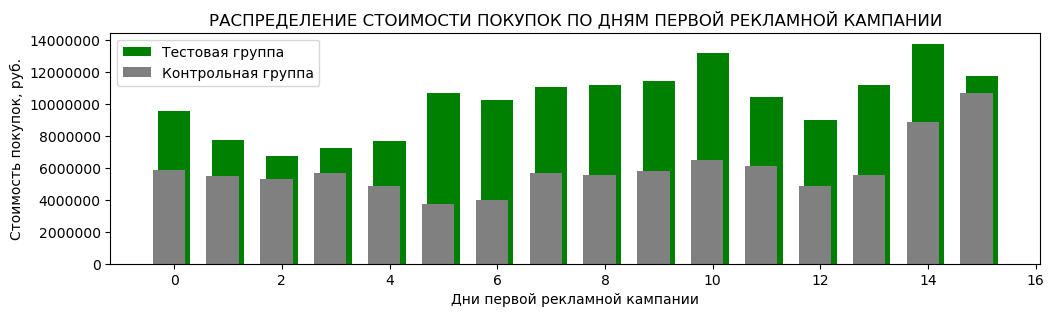

In [11]:
# Визуализируем распределения
fig, ax = plt.subplots(figsize=(12, 3))
ax.set_title('РАСПРЕДЕЛЕНИЕ СТОИМОСТИ ПОКУПОК ПО ДНЯМ ПЕРВОЙ РЕКЛАМНОЙ КАМПАНИИ')
ax.set_ylabel('Стоимость покупок, руб.')
ax.set_xlabel('Дни первой рекламной кампании')
ax.bar(df_test_cost.index, df_test_cost['cost'], width=0.6,
       color='green', label='Тестовая группа')
ax.bar(df_control_cost.index-0.1, df_control_cost['cost'], width=0.6,
       color='gray', label='Контрольная группа')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
plt.legend();

**Вывод:** Первая рекуламная кампании значительно увеличила стоимость продаж практически в каждый день её проведения.

### 3.2.2. Проверим метрики "Изменение частоты покупок"

In [12]:
# Сформируем выборки по частоте покупок покупателями
df_test_client = df_test.groupby('id').agg({'product': 'count'})
df_control_client = df_control.groupby('id').agg({'product': 'count'})

In [13]:
# Применим разработанный класс (см. файл package.select_run_test)
# для определения статистически значисого отличия сформированных выборок
test = SampleComparisonTest(print_console_flag=True)
test.select_run_test(df_test_client['product'], df_control_client['product'])


Пользователь задал условие - выборки НЕЗАВИСИМЫЕ

 Проверка каждой выборки на прараметричность тестом Шапира-Уилка
 ЗНАЧЕНИЯ p-value ВЫБОРОК
  - первая выборка: 0.000000%
  - вторая выборка: 0.000000%
--------------------------------------
 ВЫВОД: Одна или все выборки НЕПАРАМЕТРИЧЕСКИЕ (не распеределены по нормальному закону распределения)


  Для сравнения выборок выбран тест: Критерий Мана-Уитни
 ЗНАЧЕНИЕ p-value при тестировании выборок: 0.000000%
-------------------------------------------------------
 ВЫВОД: выборки статистически значимо РАЗЛИЧАЮТСЯ (гипотеза H1)


{'Условие зависимости выборок': 'no_dependency',
 'Предпроверка 1': {'name_test': 'Тест Шапиро',
  'p-value df1': 0.0,
  'p-value df2': 0.0},
 'Результат': {'name_test': 'Критерий Мана-Уитни',
  'p-value': 4.0493932665489114e-109}}

/Users/work/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/work/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


OptionError: "No such keys(s): 'mode.use_inf_as_null'"

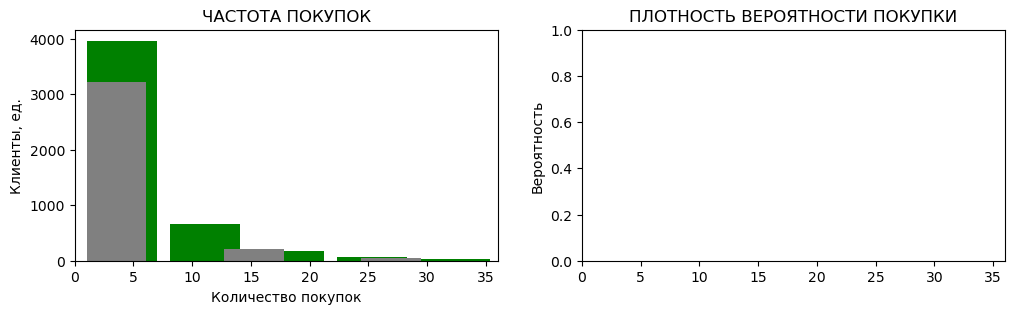

In [18]:
# Визуализируем распределения
fig, axs = plt.subplots(1, 2, figsize=(12, 3))
axs[0].set_title('ЧАСТОТА ПОКУПОК')
axs[0].set_ylabel('Клиенты, ед.')
axs[0].set_xlabel('Количество покупок')
axs[0].set_xlim(0, 36)
axs[1].set_title('ПЛОТНОСТЬ ВЕРОЯТНОСТИ ПОКУПКИ')
axs[1].set_ylabel('Вероятность')
axs[1].set_xlim(0, 36)
axs[0].hist(df_test_client['product'], color='green',  width=+6)
axs[0].hist(df_control_client['product'], color='gray', width=+5.1)
axs[1] = sns.distplot(df_test_client['product'], hist=False, kde=True, color='green',
                      label='Тестовая группа', kde_kws = {'linewidth': 3})
axs[1] = sns.distplot(df_control_client['product'], hist=False, kde=True, color='gray',
                      label='Контрольная группа', kde_kws = {'shade': True, 'linewidth': 2})
plt.xlabel('Количество покупок')
plt.legend();

**Вывод:** Значительно возрасло количество клиентов, совершивших несколько покупок, что свидетельствует об эффективности рекланой кампании, которая привлекает клиентов за повторными покупками. Частота покупок, а следовательно и посещений клиентами магазинов стало более равномерным что позитивно для нагрузки на инфраструктуру обслуживания, так как требует более равного количества обслуживающего персонала в разные периоды работы магазинов. Это также подтверждается возросшей плотностью вероятности покупок (посещений) практисчески у всех клиентов, совершивших 3 и более покупок.

### 3.2.3. Проверим метрики "Увеличение частоты и суммы покупок наиболее состоятельными клиентами"

In [19]:
# Функция разметки данных по возрастным категориям 
# данные из статьи: https://blog.domclick.ru/ipoteka/post/kazhduyu-desyatuyu-ipoteku-v-sbere-berut-molodye-lyudi-analitika-domklik
def age_rank(age):
    if   age < 26: return 1 # меньшие доходы
    elif age < 31: return 2 # средние доходы
    elif age < 41: return 3 # наибольшие доходы
    elif age < 51: return 3 # наибольшие доходы
    elif age < 61: return 2 # средние доходы
    else: return 1 # меншие доходы
    
# Разметим данные 
df_test['age_rank'] = df_test['age'].apply(lambda x: age_rank(x))
df_control['age_rank'] = df_control['age'].apply(lambda x: age_rank(x))

/var/folders/5h/1vkpjwr90l19cmzfgsfrcpvm0000gn/T/ipykernel_69518/2882487264.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['age_rank'] = df_test['age'].apply(lambda x: age_rank(x))
/var/folders/5h/1vkpjwr90l19cmzfgsfrcpvm0000gn/T/ipykernel_69518/2882487264.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_control['age_rank'] = df_control['age'].apply(lambda x: age_rank(x))


In [20]:
# Сформируем выборки по возрастным категориям и стоимости покупок
df_test_age = df_test.groupby('age_rank').agg({'cost': 'sum'})
df_control_age = df_control.groupby('age_rank').agg({'cost': 'sum'})

In [21]:
# Применим разработанный класс (см. файл package.select_run_test)
# для определения статистически значисого отличия сформированных выборок
test = SampleComparisonTest(print_console_flag=True)
test.select_run_test(df_test_age['cost'], df_control_age['cost'])


Пользователь задал условие - выборки НЕЗАВИСИМЫЕ

 Проверка каждой выборки на прараметричность тестом Шапира-Уилка
 ЗНАЧЕНИЯ p-value ВЫБОРОК
  - первая выборка: 6.376481%
  - вторая выборка: 8.279554%
--------------------------------------
 ВЫВОД: Все выборки ПАРАМЕТРИЧЕСКИЕ (распеределены по нормальному закону распределения)

 Проверка равенства Дисперсий выборок тестом Левене
 ЗНАЧЕНИЕ p-value: 75.567725%
--------------------------------------
 ВЫВОД: Дисперсии выборок - РАВНЫЕ


  Для сравнения выборок выбран тест: Т-критерий Стьюдента
 ЗНАЧЕНИЕ p-value при тестировании выборок: 38.020606%
-------------------------------------------------------
 ВЫВОД: выборки статистически значимо НЕ ИМЕЮТ РАЗНИЦЫ (гипотеза H0)


{'Условие зависимости выборок': 'no_dependency',
 'Предпроверка 1': {'name_test': 'Тест Шапиро',
  'p-value df1': 0.06376481056213379,
  'p-value df2': 0.08279553800821304},
 'Предпроверка 2': {'name_test': 'Тест Левене', 'p-value': 0.7556772546730324},
 'Результат': {'name_test': 'Т-критерий Стьюдента',
  'p-value': 0.3802060638211032}}

In [22]:
# Сформируем выборки по возрастным категориям и частоте покупок
df_test_age = df_test.groupby('age_rank').agg({'product': 'count'})
df_control_age = df_control.groupby('age_rank').agg({'product': 'count'})

In [23]:
# Применим разработанный класс (см. файл package.select_run_test)
# для определения статистически значисого отличия сформированных выборок
test = SampleComparisonTest(print_console_flag=True)
test.select_run_test(df_test_age['product'], df_control_age['product'])


Пользователь задал условие - выборки НЕЗАВИСИМЫЕ

 Проверка каждой выборки на прараметричность тестом Шапира-Уилка
 ЗНАЧЕНИЯ p-value ВЫБОРОК
  - первая выборка: 13.581397%
  - вторая выборка: 11.491381%
--------------------------------------
 ВЫВОД: Все выборки ПАРАМЕТРИЧЕСКИЕ (распеределены по нормальному закону распределения)

 Проверка равенства Дисперсий выборок тестом Левене
 ЗНАЧЕНИЕ p-value: 71.835853%
--------------------------------------
 ВЫВОД: Дисперсии выборок - РАВНЫЕ


  Для сравнения выборок выбран тест: Т-критерий Стьюдента
 ЗНАЧЕНИЕ p-value при тестировании выборок: 39.650172%
-------------------------------------------------------
 ВЫВОД: выборки статистически значимо НЕ ИМЕЮТ РАЗНИЦЫ (гипотеза H0)


{'Условие зависимости выборок': 'no_dependency',
 'Предпроверка 1': {'name_test': 'Тест Шапиро',
  'p-value df1': 0.13581396639347076,
  'p-value df2': 0.11491381376981735},
 'Предпроверка 2': {'name_test': 'Тест Левене', 'p-value': 0.7183585280977867},
 'Результат': {'name_test': 'Т-критерий Стьюдента',
  'p-value': 0.39650172030040165}}

**Вывод:** проведение рекламной кампании не позволило увеличить стоимость и частоту покупок более состоятельной группой клиентов.

**Общие выводы**:
1) Рекламная кампания мотивировала большее количество клиентов на повторные покупки и значительно увеличила выручку. Это с одно стороны позволит снизить издержк и на инфраструктуру обслуживания клинетов, так как она будет загружена более равномерно, а с другой стороны увеличит доходы за счёт повтороного возврата клиентов, ожидающих дополнительных акций. Для поддержания эффекта целесообразно посторять такие рекламные кампании с сезонной периодичночтью.  
2) Однако, в отношении наиболее состоятельных групп клиентов - в будущих кампаниях рекомендуется акцентировать внимание на конкретных возростных групах, таким образом, чтобы наиболее сильно мотивировать к повторным покупкам группы клиентов со средним и высоким доходом (от 31 до 61 года), которые смогут в будущем совершать более дорогие и более частые покупки.

## 3.3. Оценка второй рекламной кампании

Поскольку вторая рекламная кампания проводилась на отдельной территории (город №1134) её эффективность можно проверить по изменившейся плотности вероятночти покупок покупателями в дни акции в данном городе в сравнении с другими городами.

In [24]:
# Получим датасет выбранный для AB тестирования второй маркетенговой компании
df_AB_2 = df_all[~df_all.test.isna()]
df_test = df_AB_2[(df_AB_2.city == 1134) & (df_AB_2.dt.isin([15, 45]))]
df_control = df_AB_2[(df_AB_2.city != 1134) & (df_AB_2.dt.isin([15, 45]))]
# Сформируем выборки по частоте покупок покупателями
df_test_client = df_test.groupby('id').agg({'product': 'count'})
df_control_client = df_control.groupby('id').agg({'product': 'count'})
print(f"Количество покупателей в городе 1134 (тестовая группа): {len(df_test_client)}")
print(f"Количество покупателей в других городах (контрольная группа): {len(df_control_client)}")

Количество покупателей в городе 1134 (тестовая группа): 796
Количество покупателей в других городах (контрольная группа): 1973


Так как вторая рекламна кампания проводилась через канал в конкретном городе, количесвто пользователей которого неконтролируется, то контрольную группу для такой кампании можно выбрать в качестве контрольной группы только покупателей на других территориях. Соответсвенно оценку проведённой рекламной кампании будем проводить по относительному показателю (плотность вероятности покупок), а значит балансировка размеров тестовой и контрольной выборок нецелесообразны.

/Users/work/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/work/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


OptionError: "No such keys(s): 'mode.use_inf_as_null'"

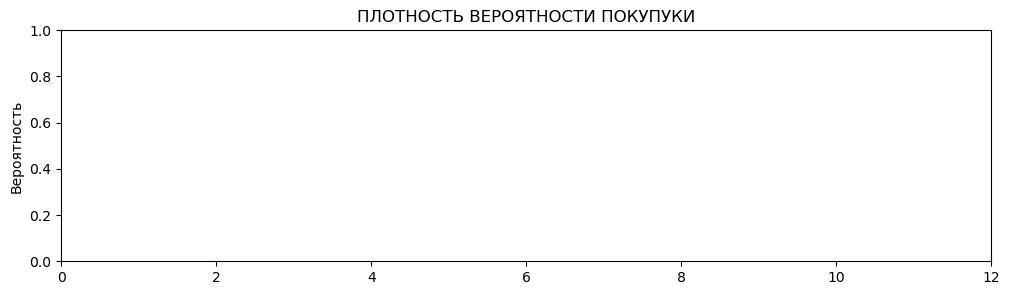

In [25]:
# Визуализируем распределения
fig, ax = plt.subplots(figsize=(12, 3))
ax.set_title('ПЛОТНОСТЬ ВЕРОЯТНОСТИ ПОКУПУКИ')
ax.set_ylabel('Вероятность')
ax.set_xlim(0, 12)
ax = sns.distplot(df_test_client['product'],hist=False, kde=True, color='green',
                  label='Тестовая группа', kde_kws = {'linewidth': 3})
ax = sns.distplot(df_control_client['product'], hist=False, kde=True, color='gray',
                  label='Контрольная группа', kde_kws = {'shade': True, 'linewidth': 2})
plt.xlabel('Количество покупок')
plt.legend();

**Вывод**: Вторая рекламная кампания снизила вероятноть 1 покупки, что является положительным фактором, в случае роста вероятности нескольких покупок, однако этого не произошло. Таким образом вторую рекламную кампанию можно прихзнать неудачной. В будущем её необходимо переработать, например сориентировав на группы с большей доходностью, либо отказаться от её проведения.

In [26]:
# Загрузим итоговый датаcет в хранилище (база данных sqlite3)
connection = db.connect('data/purchases.db')
print("База данных подключена")
df_all.to_sql("full_table", connection, if_exists="replace", index=False)
print("Таблица заполнена")
connection.close()
print("Соединение с базой данных закрыто")

База данных подключена
Таблица заполнена
Соединение с базой данных закрыто


In [28]:
# Оптимизируем используемую память
# Определяем список загруженных датафреймов
dfs = []
local_variable_scope =locals().keys()
for elem in local_variable_scope:
    if 'df' in elem:
        dfs.append(elem)
# Удаляем не используемые датафреймы
for elem in dfs:
    del locals()[elem]